## **Experimental data in KICT**
1. Indexing the main events (shifts of the structure)
2. EDA for the main events
> **3. Anomaly detection**

- Inputs: Wave (i.e., height)
- Outputs: Structural responses (i.e., acc, tilt, disp)

writteny by seungsab (2022.09.27)

<center> <p>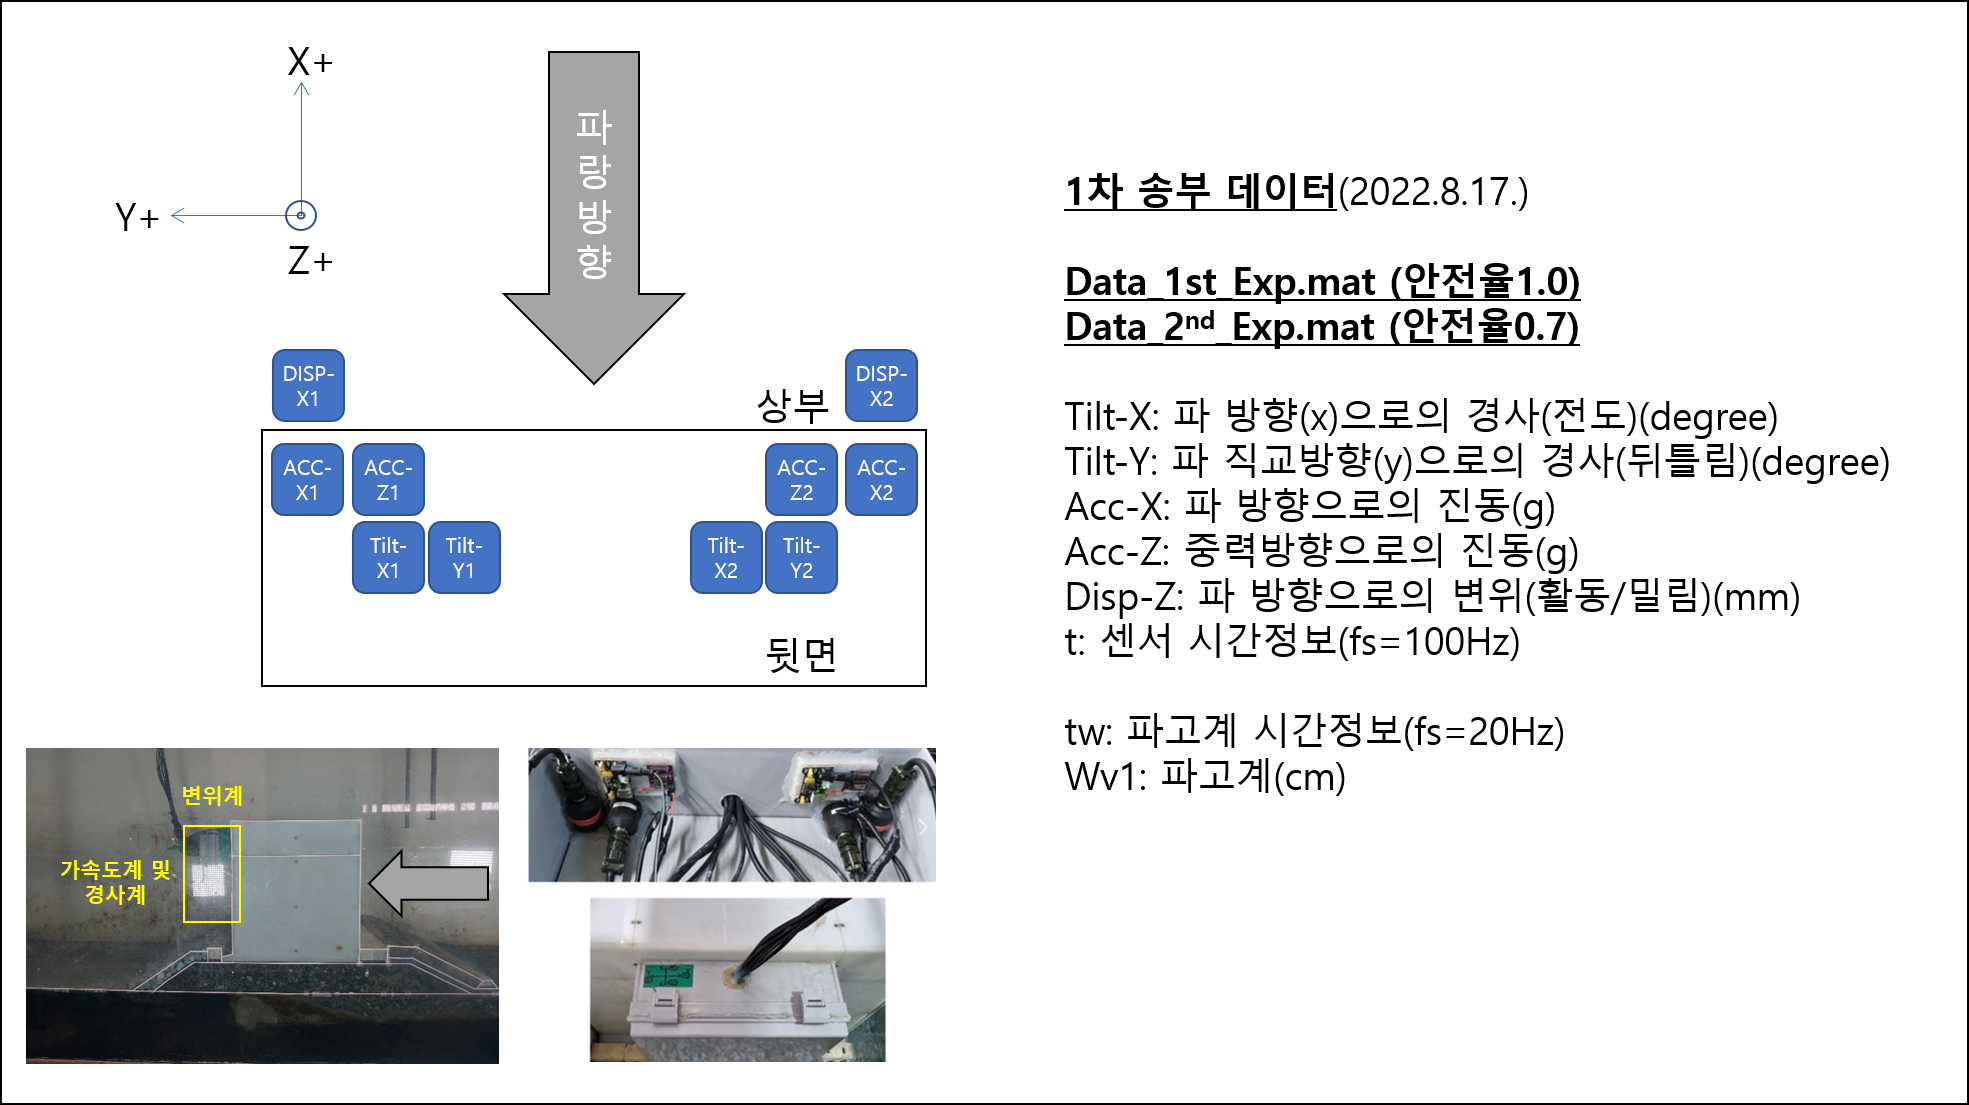</p> </center>

#### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import scipy.io

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

#### **Load Preprocessed data**

In [2]:
# Load Preprocessed data
import pickle, gzip

with gzip.open('Preprocess_data_with_labels.pickle','rb') as f:
    Preprocess_data_with_labels = pickle.load(f)

# Assign the variables in the dictorinary
for key, value in Preprocess_data_with_labels.items():
    locals()[key] = value
print(Preprocess_data_with_labels.keys())

# Convert pandas data into list
ind_time_no_wave = df_no_wave.iloc[:, 0:2].values.tolist() # Times for the periods w/o waves
ind_x_lim = df_no_wave.iloc[:, 2:].values.tolist()
time_failure1 = df_failure_time.iloc[:, 0].values.tolist() # for only dispX1
time_failure2 = df_failure_time.iloc[:, 1].values.tolist() # for only dispX2
time_failure12 = sorted(list(set(time_failure1 + time_failure2))) # for both dispX1 and dispX2

dict_keys(['fn', 'df_no_wave', 'df_failure_time', 'df_wv', 'df_sensor'])


#### **Plot lineplot of signals**

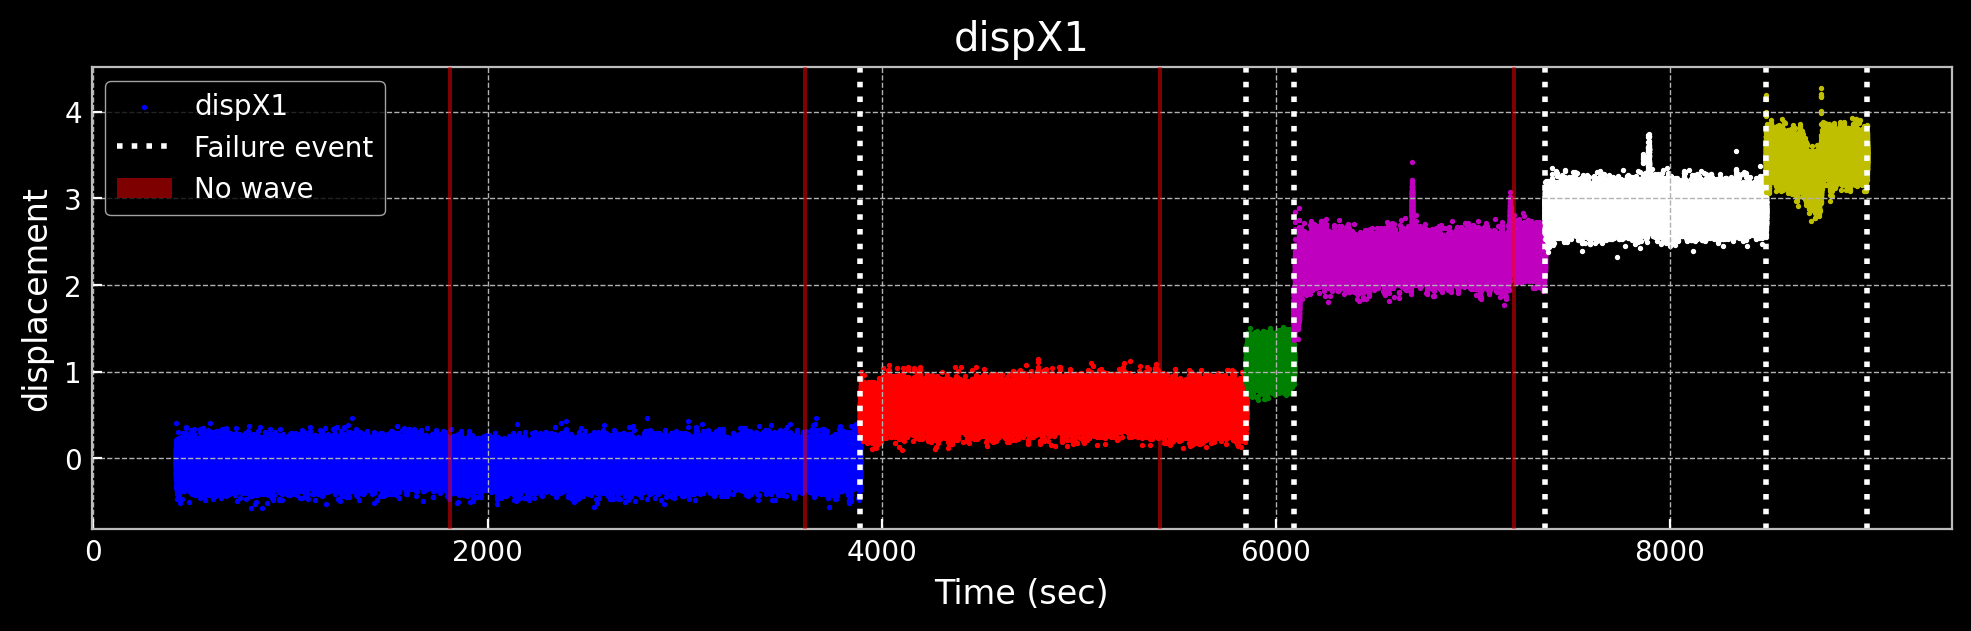

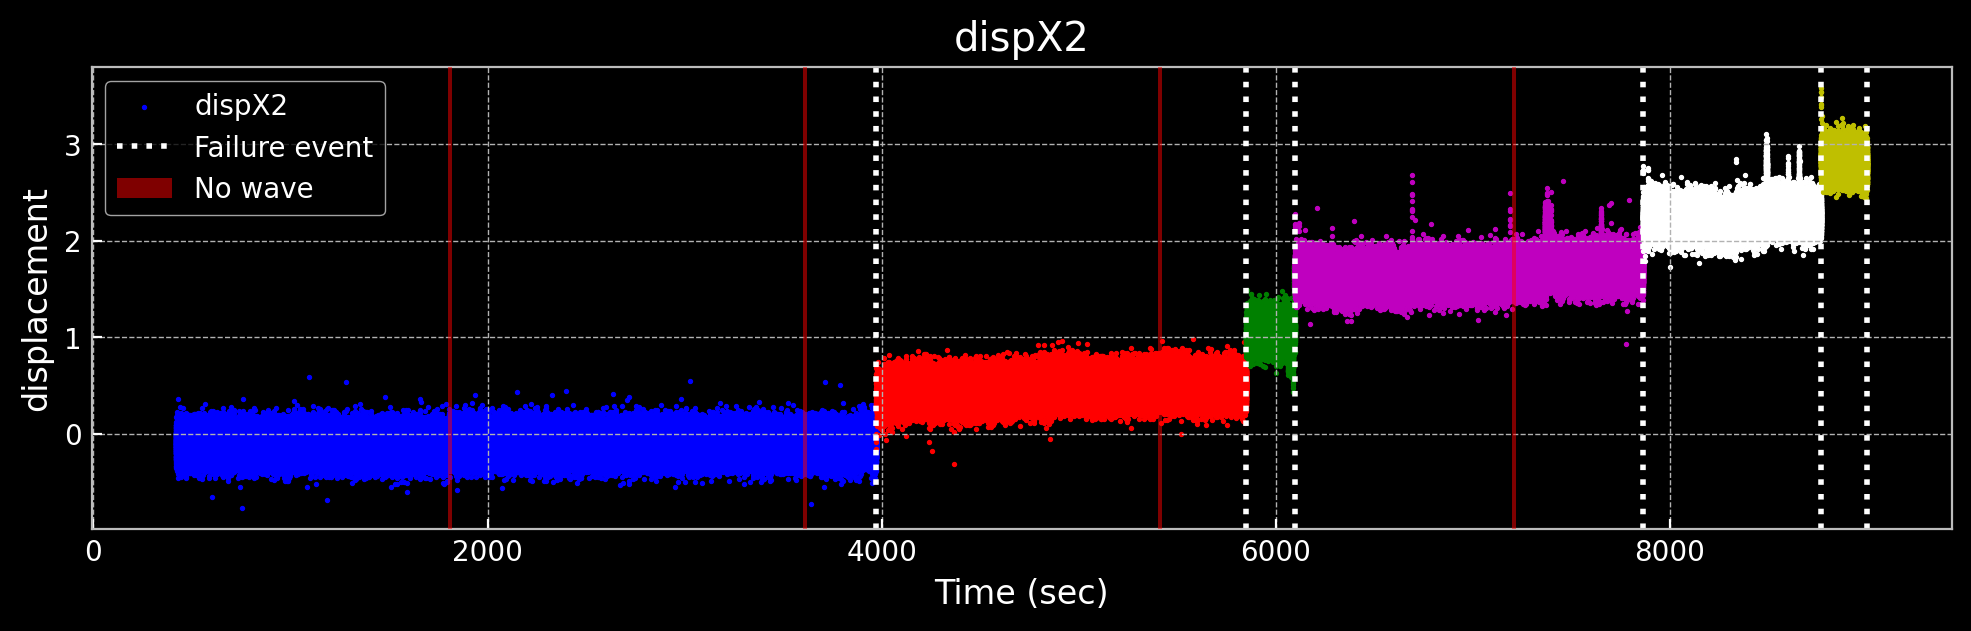

In [3]:
from Utils.SS_fcnt_for_KICT_experiment import lineplot_with_segmentation, set_plot_style

set_plot_style()

df, col_name, seg_name = df_sensor, 'dispX1', '#segment1'
lineplot_with_segmentation(df, col_name, seg_name, ind_time_no_wave)

df, col_name, seg_name = df_sensor, 'dispX2', '#segment2'
lineplot_with_segmentation(df, col_name, seg_name, ind_time_no_wave)

#### **Define inliers and outliers**

In [4]:
# Define new Dataframe for anomaly detection
df_wave = df_wv[['Wv1', '#segment1', '#segment2']]
df_disp = df_sensor[['dispX1', 'dispX2', '#segment1', '#segment2']]

In [5]:
# Define inliers and outliers
df_wave['outlier'] = ((df_wave['#segment1'] * df_wave['#segment2']) > 0).astype(int)
df_disp['outlier'] = ((df_disp['#segment1'] * df_disp['#segment2']) > 0).astype(int)

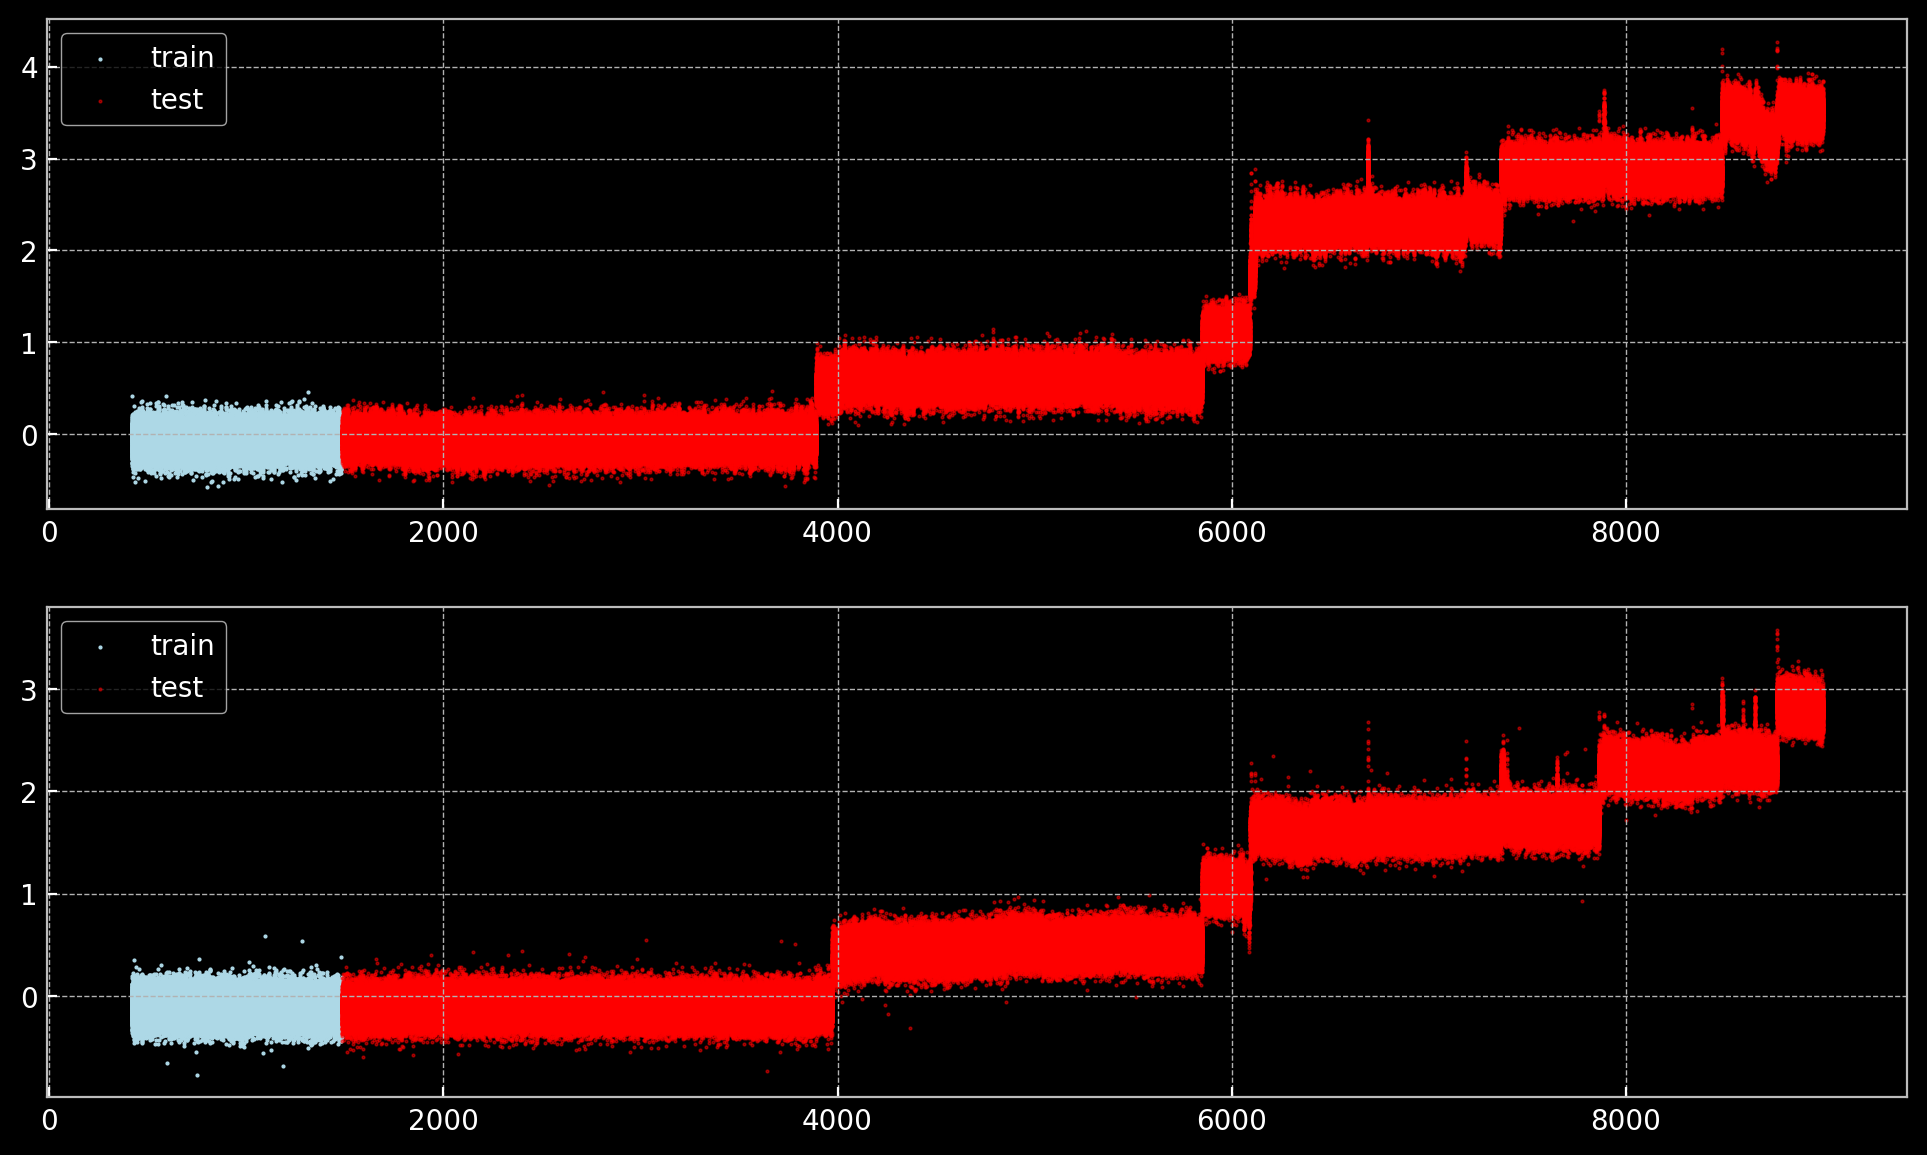

# Train : 106604, # Test: 751396


In [6]:
from Utils.SS_fcnt_for_KICT_experiment import train_test_split
df_train, df_test = train_test_split(df_disp, train_ratio = 0.3)
print(f'# Train : {df_train.shape[0]}, # Test: {df_test.shape[0]}')

#### **Data normalization**

##### ***Standardization***

In [7]:
from sklearn.preprocessing import StandardScaler

col_name = ['dispX1', 'dispX2']
Xtrain = df_train[col_name].values
Xtest = df_test[col_name].values

scaler = StandardScaler()
Xtrain_std = scaler.fit_transform(Xtrain)
Xtest_std = scaler.transform(Xtest)

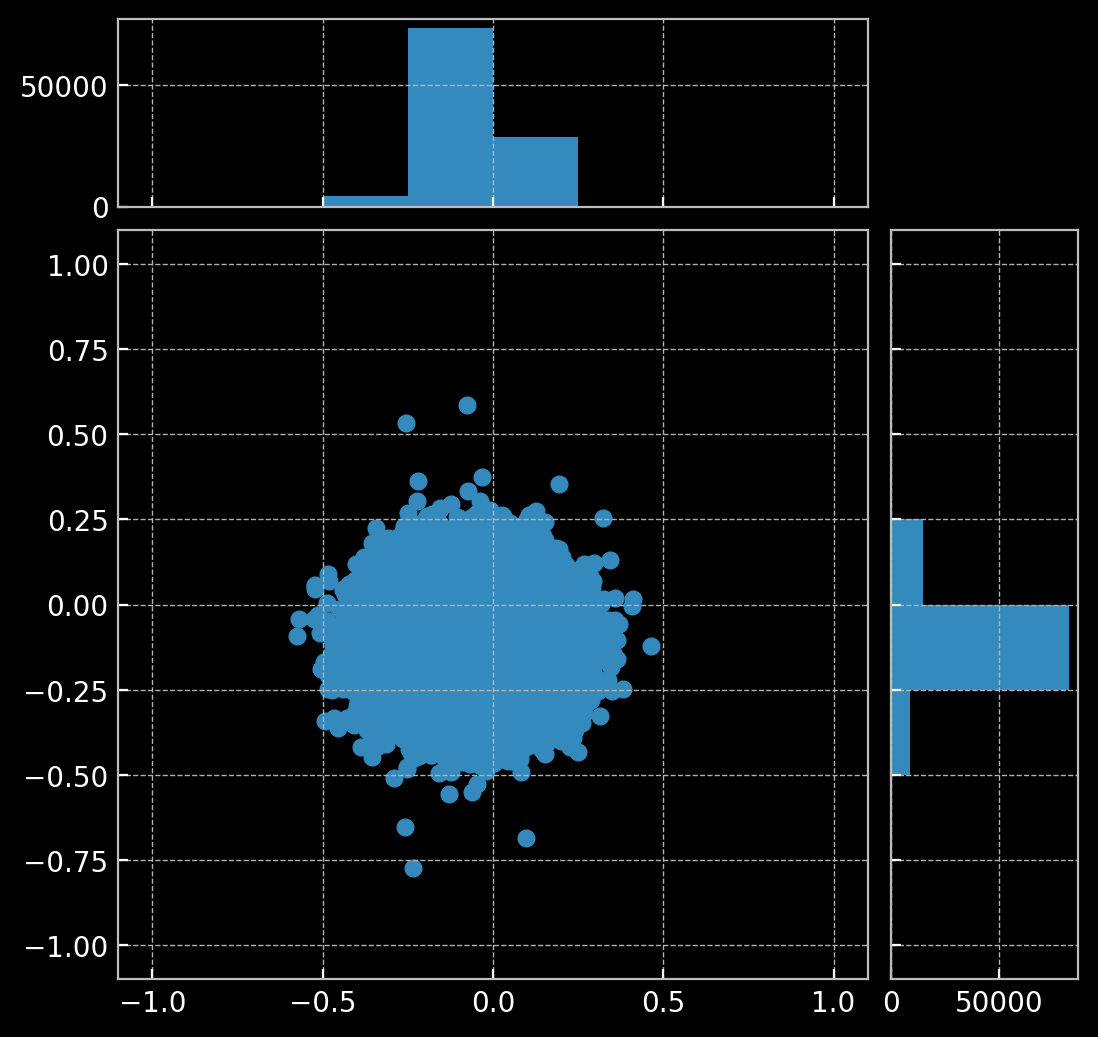

In [8]:
from Utils.SS_fcnt_for_KICT_experiment import plot_scatter_with_hist
x, y = Xtrain[:, 0], Xtrain[:, 1]
plot_scatter_with_hist(x, y)

#### **Anomaly detection method #1: GMM**
[Gaussian Mixture Model (GMM) for Anomaly Detection](https://medium.com/grabngoinfo/gaussian-mixture-model-gmm-for-anomaly-detection-e8360e6f4009)  

[Gaussian Mixture Model Selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py)

##### ***Define Automated model selection using BIC criterion***

In [9]:
def fit_best_GMM(X, n_comp_min = 1, n_comp_max = 5, cv_types = ["spherical", "tied", "diag", "full"]):
    import numpy as np
    import itertools

    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    from sklearn import mixture

    print(X.shape)
    if X.shape[1] == 1:
        cv_types = 'Uni'

    lowest_bic = np.infty
    fitted_gmms, bic = [], []
    n_components_range = range(n_comp_min, n_comp_max)
    cv_types = cv_types
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            if X.shape[1] == 1:
                gmm = mixture.GaussianMixture(n_components = n_components)
            else:
                gmm = mixture.GaussianMixture(
                    n_components = n_components, covariance_type = cv_type)
            gmm.fit(X)
            fitted_gmms.append(gmm)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    return fitted_gmms, best_gmm, bic

In [10]:
from Utils.SS_fcnt_for_KICT_experiment import get_index_by_time

def plot_GMM_result(df, col_names, t_interest, pct_threshold, figsizes = (12, 9)):
    ind1 = get_index_by_time(df, t_interest[0])
    ind2 = get_index_by_time(df, t_interest[1])
    
    colors = 'brgmwy'
    fig, axs = plt.subplots(len(col_names), 1, figsize = figsizes)
    for idx, col in enumerate(col_names):
        ymin, ymax = df[col].iloc[ind1:ind2].min(), df[col].iloc[ind1:ind2].max()
        for ind in df[seg_name].unique():
            ind_seg = (df[seg_name] == ind)
            df_ = df.loc[ind_seg, col]

            a = axs[idx].scatter(df_.index, df_, c = colors[ind], s = 2)
            b = axs[idx].axvline(df_.index[-1], color = 'w', linestyle = ':')
        axs[idx].set_title(col)
        axs[idx].set_xlim(t_interest)
        axs[idx].set_ylim(ymin, ymax)
    
    axs[-1].axhline(pct_threshold, c = 'w')
    plt.show()

##### ***Case 1: Multi-variate data (N-by-2 arrays) : dispX1, dispX2***

In [11]:
# Automatic model selection for GMM
cv_types = ["spherical", "tied", "diag", "full"]
fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_std, n_comp_min = 1, n_comp_max = 5, cv_types = cv_types)

df_gmm = []
for gmm, bic in zip(fitted_gmm, bics):
    df_gmm.append([gmm.covariance_type, gmm.n_components, bic])
df_gmm = pd.DataFrame(df_gmm, columns = ['covariance_type', 'n_component', 'bic'])
df_gmm.sort_values(by=['bic'], ignore_index = True)

(106604, 2)


,covariance_type,n_component,bic
0,tied,1,605078.685574
1,full,1,605078.685574
2,spherical,1,605092.824204
3,diag,1,605104.401080
4,diag,2,605416.673041
5,spherical,2,605434.844339
6,full,2,605687.356010
7,tied,2,605688.361211
8,full,4,605753.208582
9,spherical,3,605880.938807


##### Compute anomaly scores (log-likelihood of mixture model) and threshold 

In [12]:
# Get the anomaly score for training data
score = best_gmm.score_samples(Xtrain_std)
df_train['Anomaly_Score'] = score

# Compute threshold from training data with significant level
significance_level = 0.3 # 99.7% inlier and 1% outlier
pct_threshold = np.percentile(score, significance_level) # 99% significnace level

outlier ratio : 0.30 %


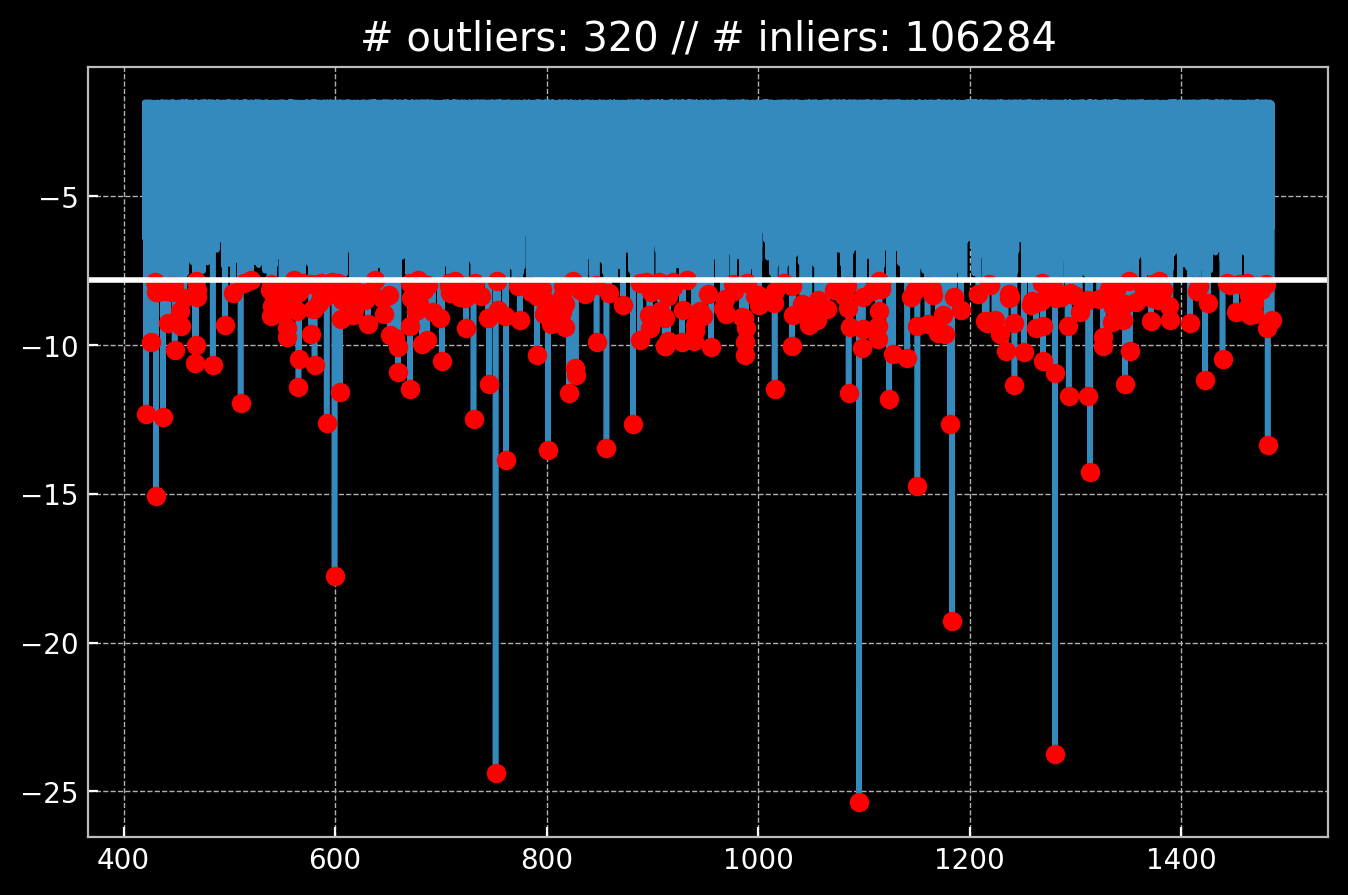

In [13]:
# Plot lnliers and outliers
outliers = (df_train['Anomaly_Score'] < pct_threshold)
print(f'outlier ratio : {outliers.sum()/df_train.shape[0] * 100:.2f} %')
plt.plot(df_train.index, df_train['Anomaly_Score'])
plt.plot(df_train.index[outliers], df_train.loc[outliers, 'Anomaly_Score'], 'ro', ls = 'None', label = 'outliers')
plt.title(f'# outliers: {outliers.sum()} // # inliers: {df_train.shape[0] - outliers.sum()}')
plt.axhline(pct_threshold, color = 'w')
plt.show()

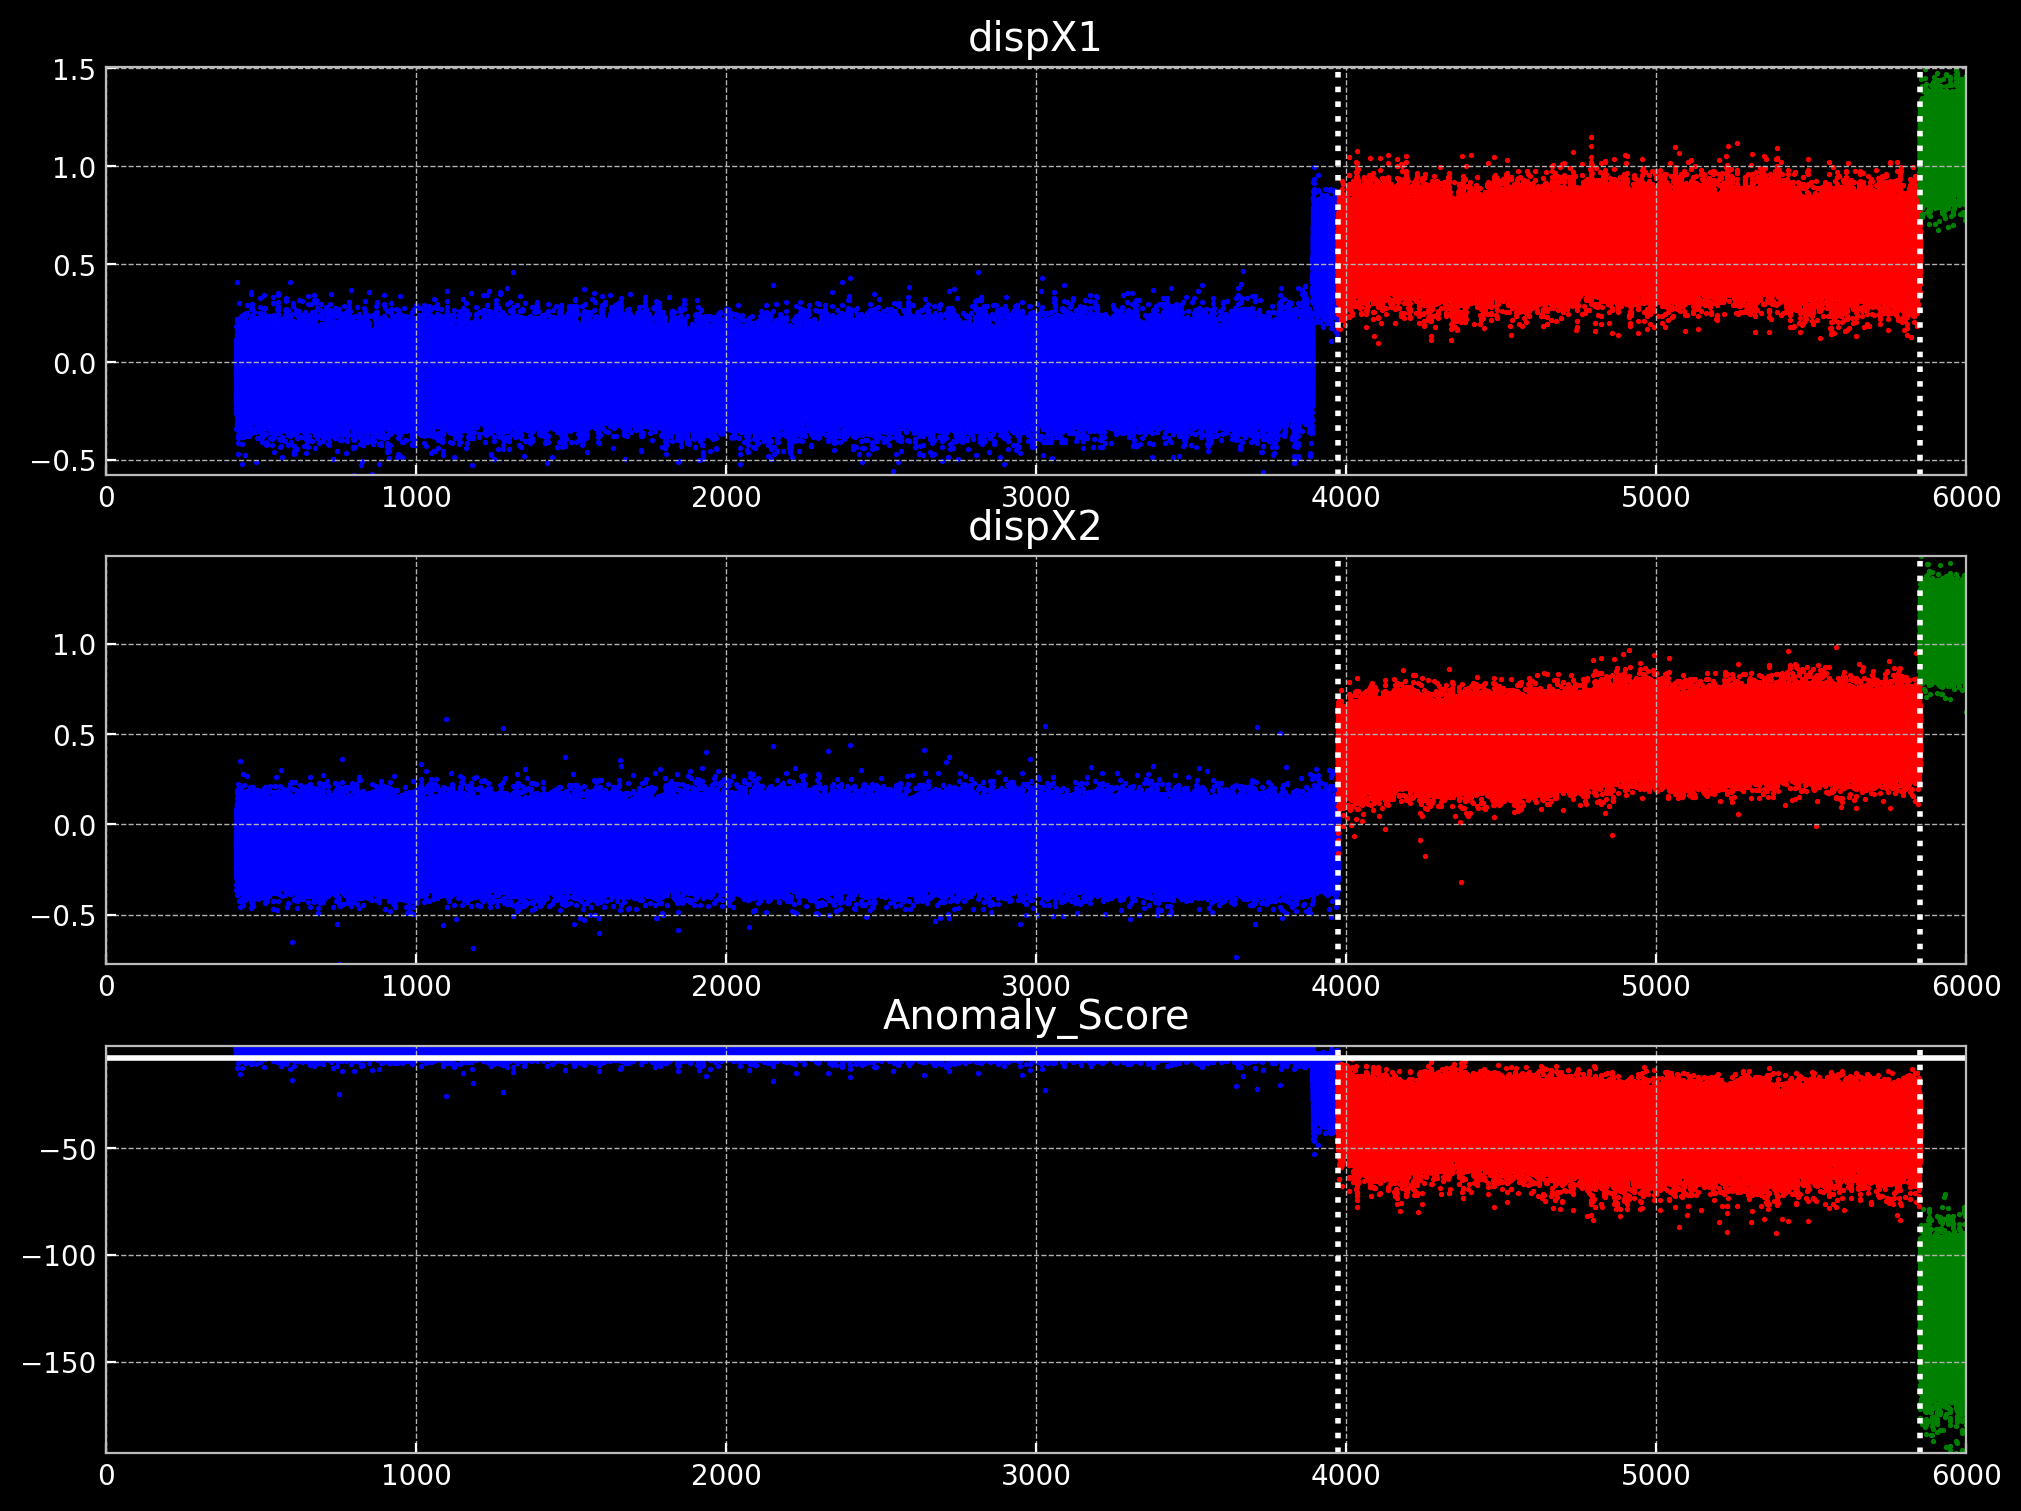

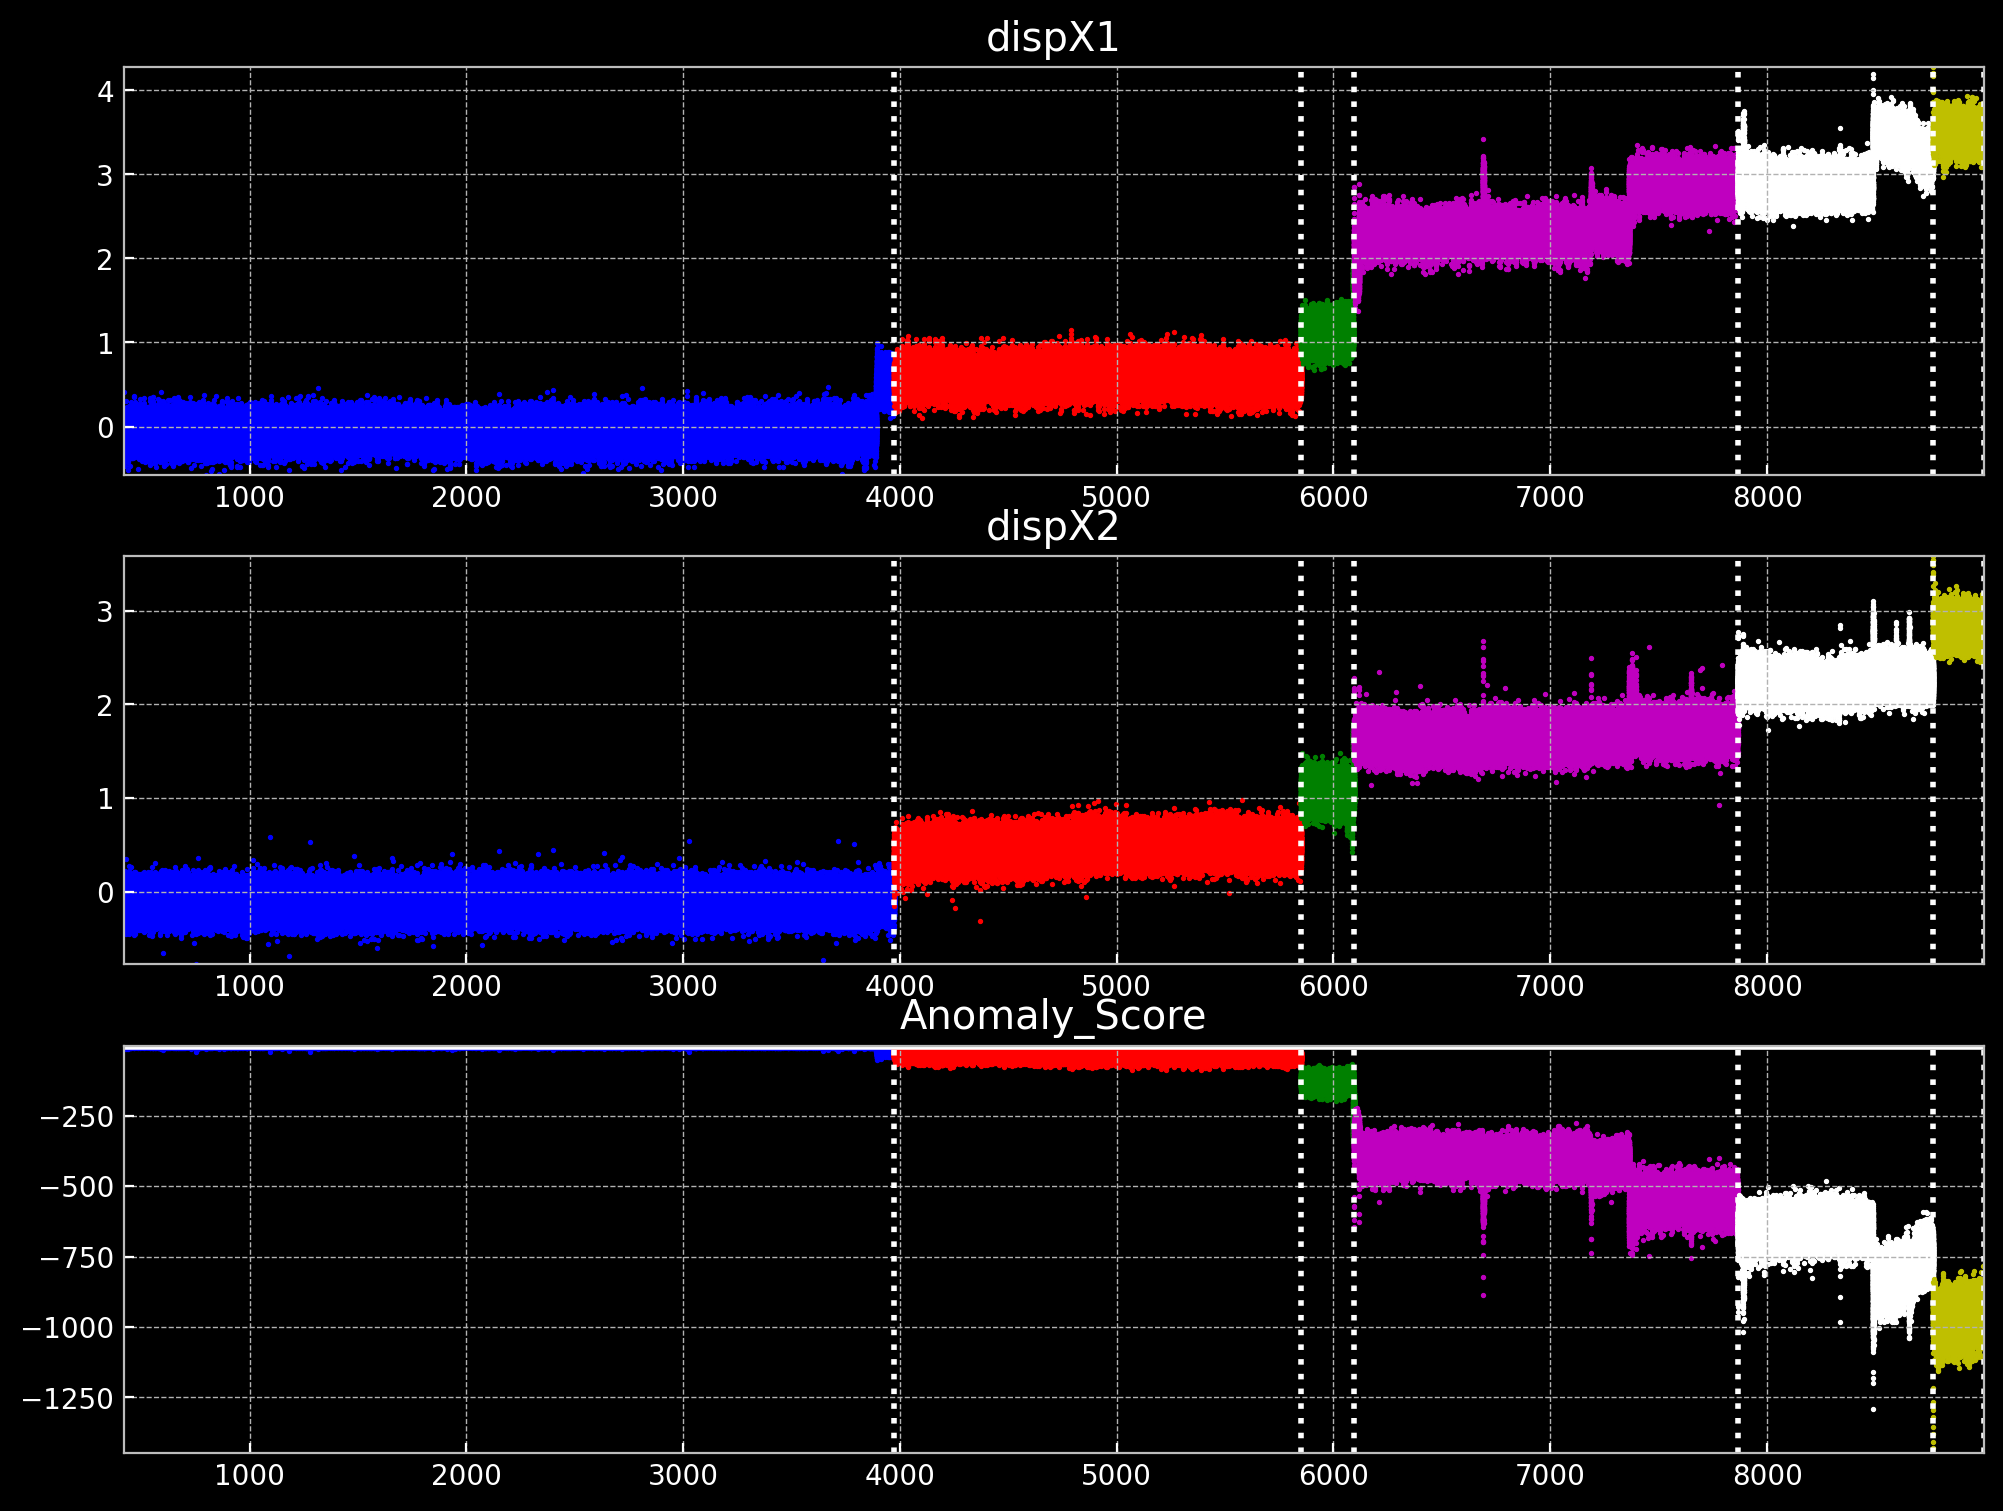

In [14]:
# Get the anomaly score for training data
score = best_gmm.score_samples(Xtest_std)
df_test['Anomaly_Score'] = score


# Plot result of Anomaly detection
col_names = ['dispX1', 'dispX2', 'Anomaly_Score']
df_all = pd.concat((df_train, df_test), axis = 0)

t_interest = (0, 6000)
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))

t_interest = (df_all.index[0], df_all.index[-1])
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))

##### ***Case 2: Uni-variate data (N-by-1 arrays) : dispX1***

(106604, 1)
outlier ratio : 0.30 %


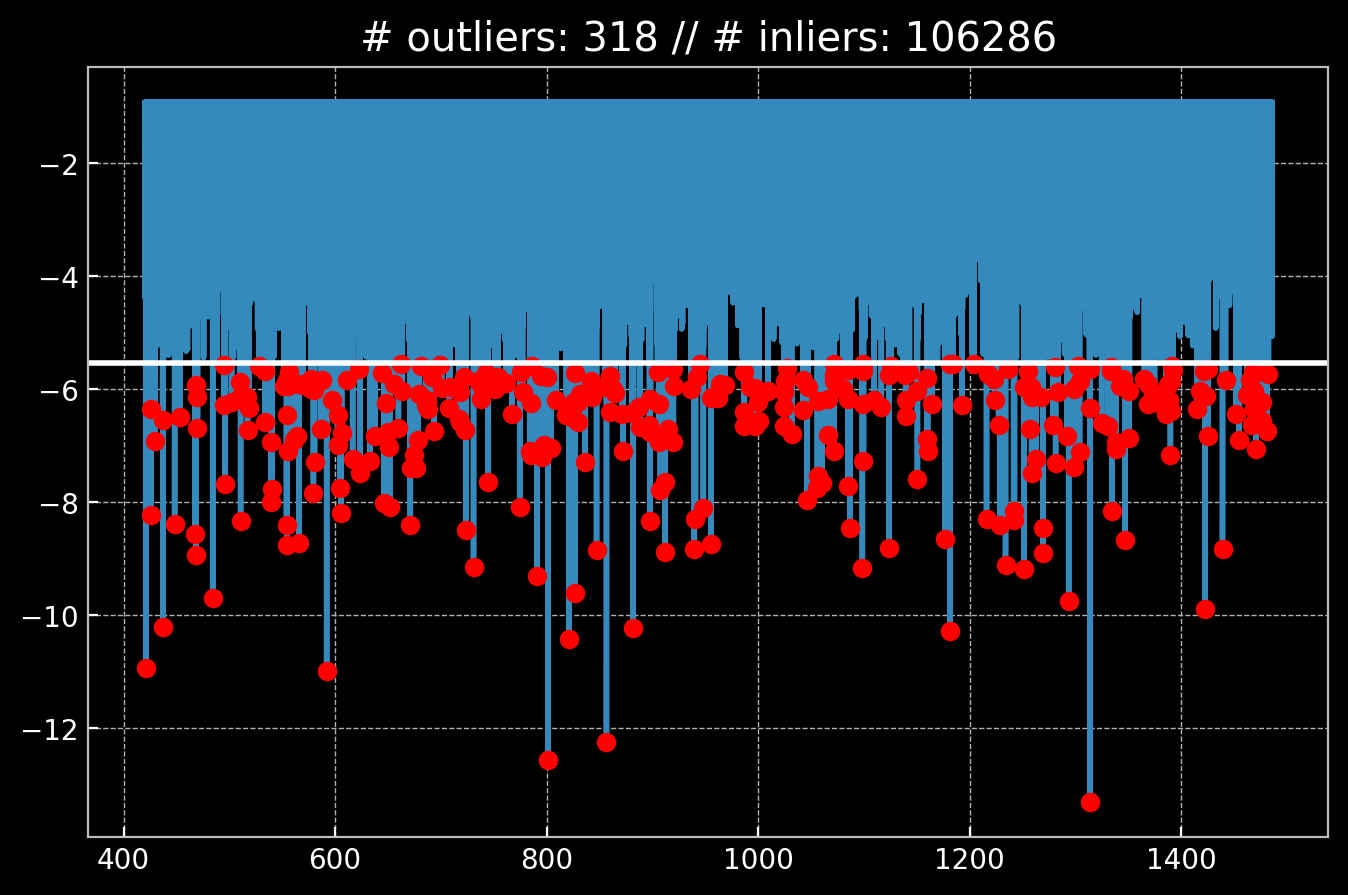

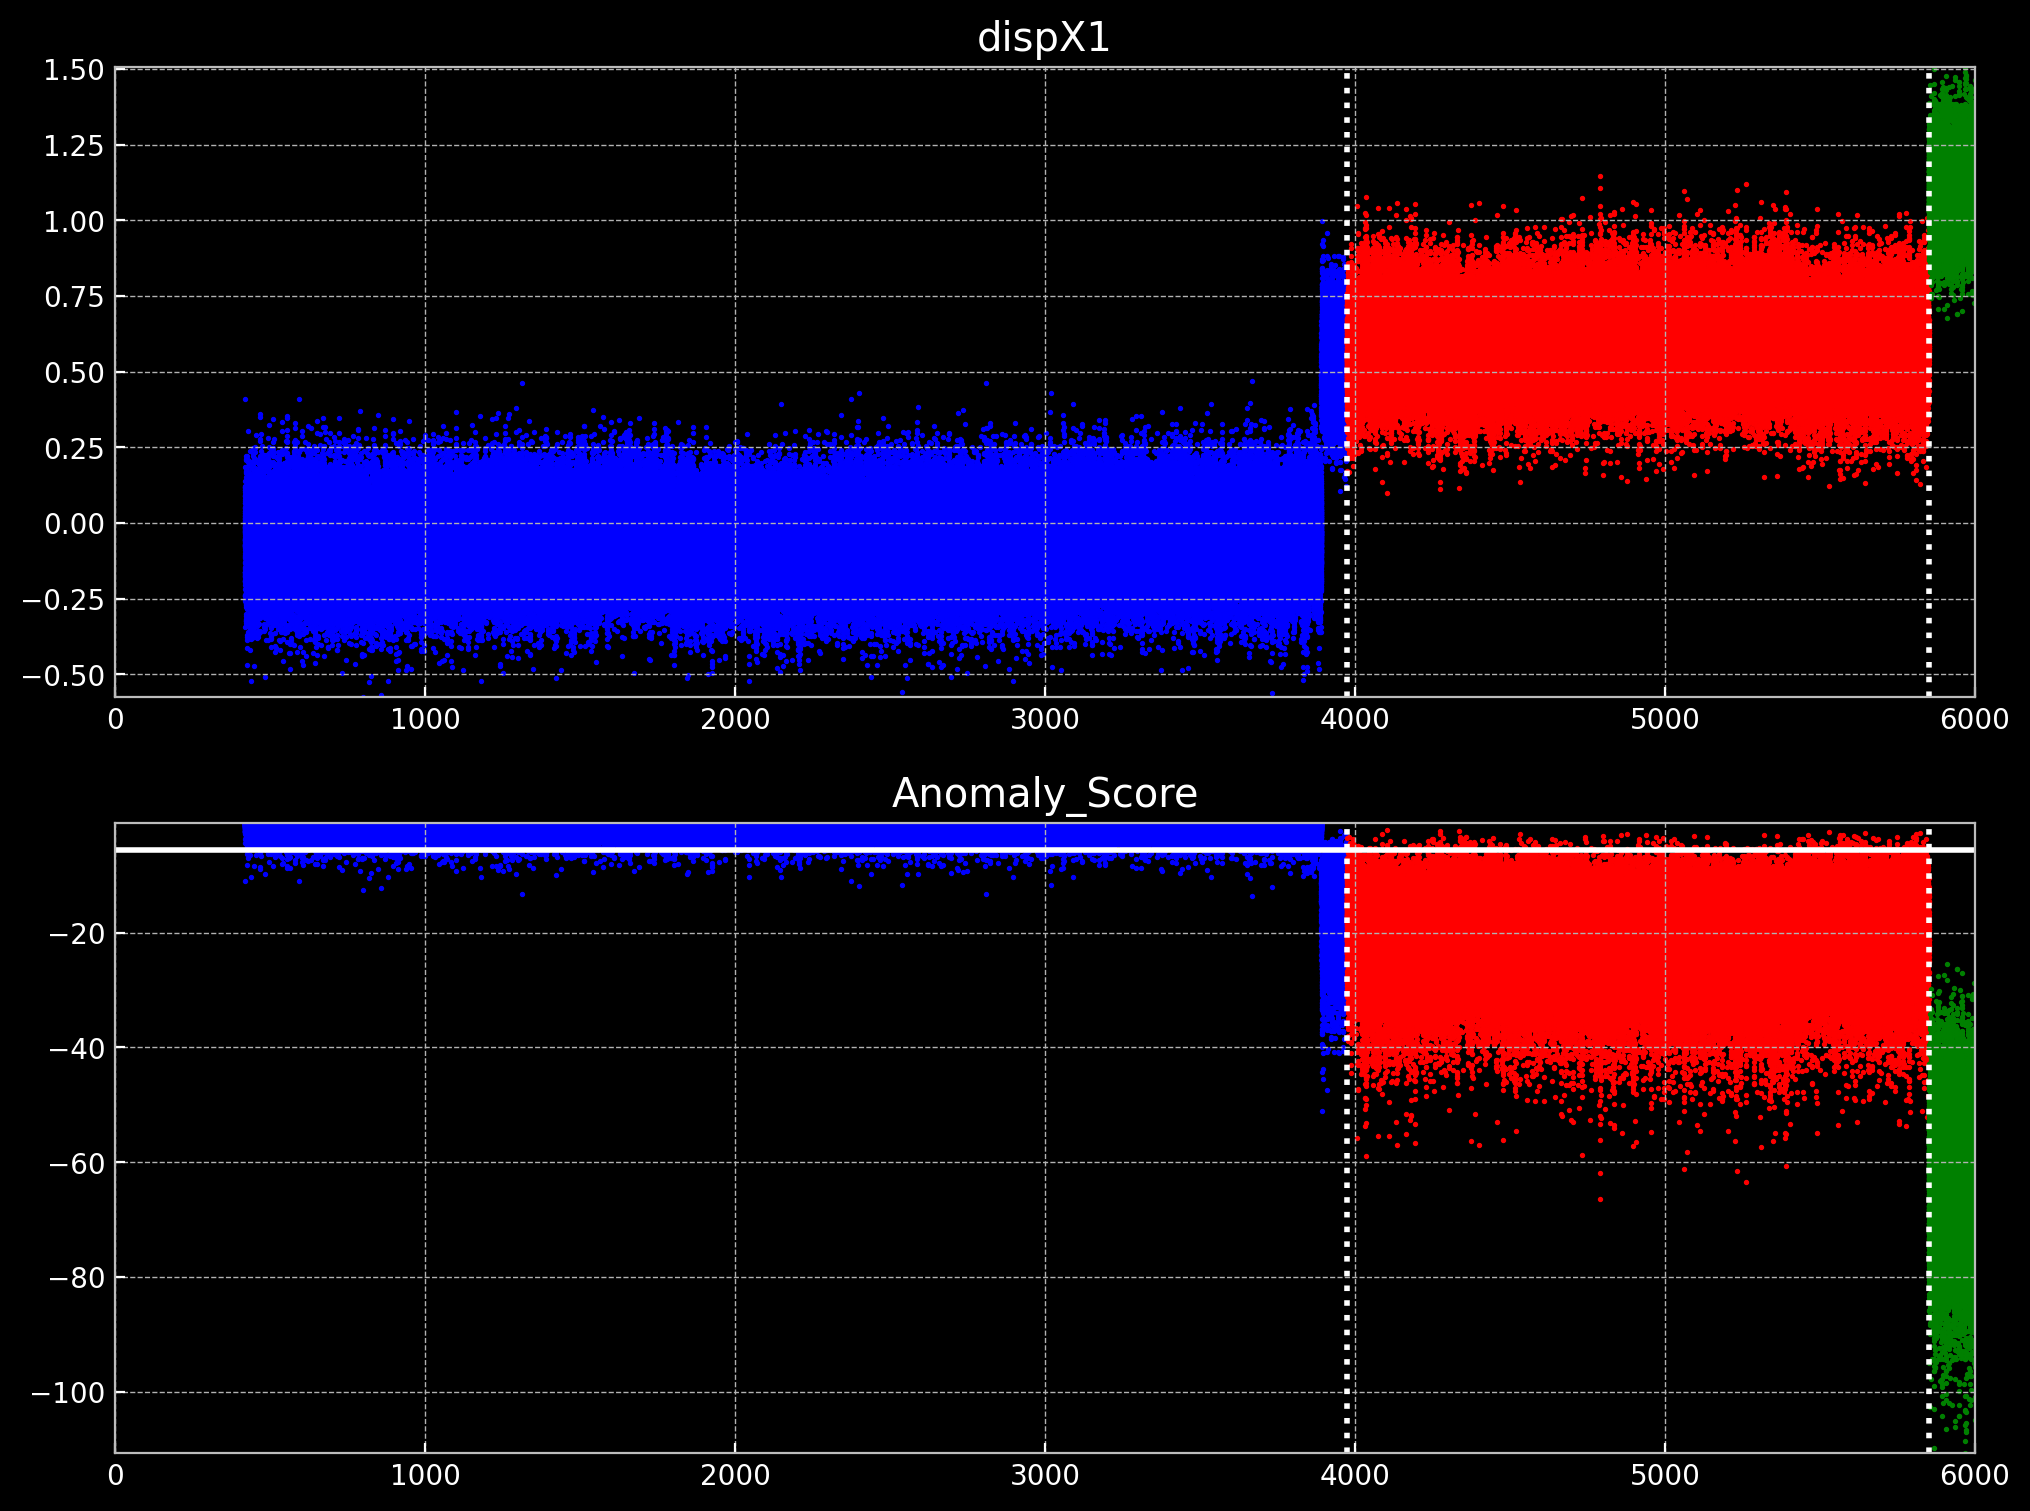

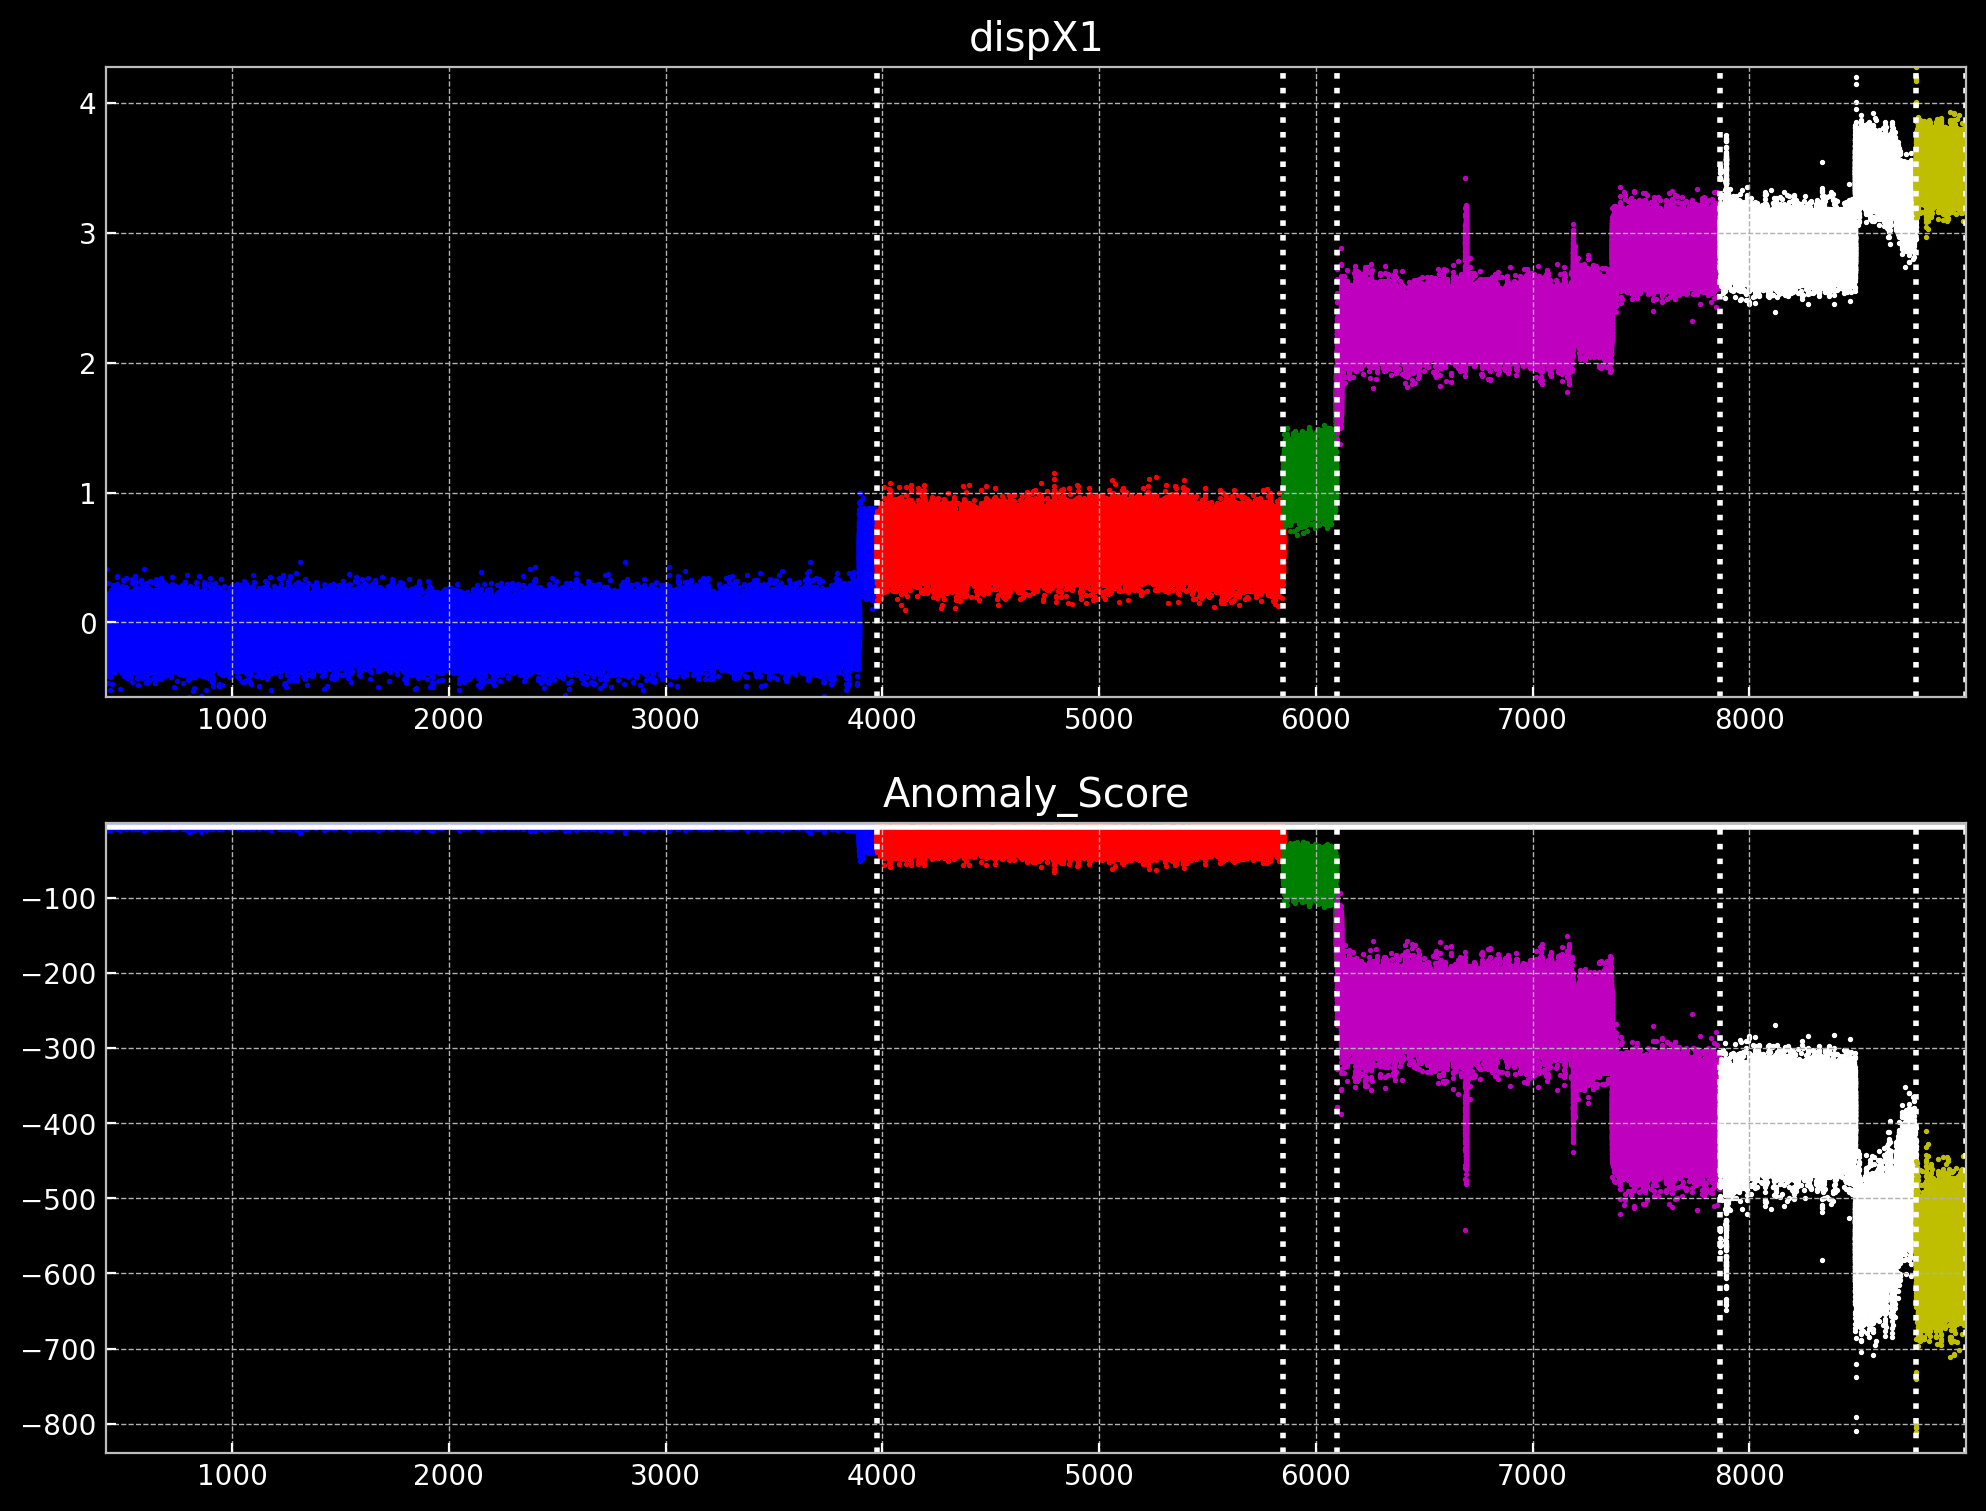

In [15]:
col_names = ['dispX1', 'Anomaly_Score']
Xtrain_uni = Xtrain_std[:, 0].reshape(-1, 1)
Xtest_uni = Xtest_std[:, 0].reshape(-1, 1)

# Automatic model selection for GMM
fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_uni, n_comp_min = 1, n_comp_max = 5)

df_gmm = []
for gmm, bic in zip(fitted_gmm, bics):
    df_gmm.append([gmm.covariance_type, gmm.n_components, bic])
df_gmm = pd.DataFrame(df_gmm, columns = ['covariance_type', 'n_component', 'bic'])
df_gmm.sort_values(by=['bic'], ignore_index = True)

# Get the anomaly score for training data
score = best_gmm.score_samples(Xtrain_uni)
df_train['Anomaly_Score'] = score

# Compute threshold from training data with significant level
pct_threshold = np.percentile(score, significance_level)

# Plot lnliers and outliers
outliers = (df_train['Anomaly_Score'] < pct_threshold)
print(f'outlier ratio : {outliers.sum()/df_train.shape[0] * 100:.2f} %')
plt.plot(df_train.index, df_train['Anomaly_Score'])
plt.plot(df_train.index[outliers], df_train.loc[outliers, 'Anomaly_Score'], 'ro', ls = 'None', label = 'outliers')
plt.title(f'# outliers: {outliers.sum()} // # inliers: {df_train.shape[0] - outliers.sum()}')
plt.axhline(pct_threshold, color = 'w')
plt.show()

# Get the anomaly score for training data
score = best_gmm.score_samples(Xtest_uni)
df_test['Anomaly_Score'] = score


# Plot result of Anomaly detection
df_all = pd.concat((df_train, df_test), axis = 0)

t_interest = (0, 6000)
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))

t_interest = (df_all.index[0], df_all.index[-1])
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))

##### ***Case 2: Uni-variate data (N-by-1 arrays) : dispX2***

(106604, 1)
outlier ratio : 0.30 %


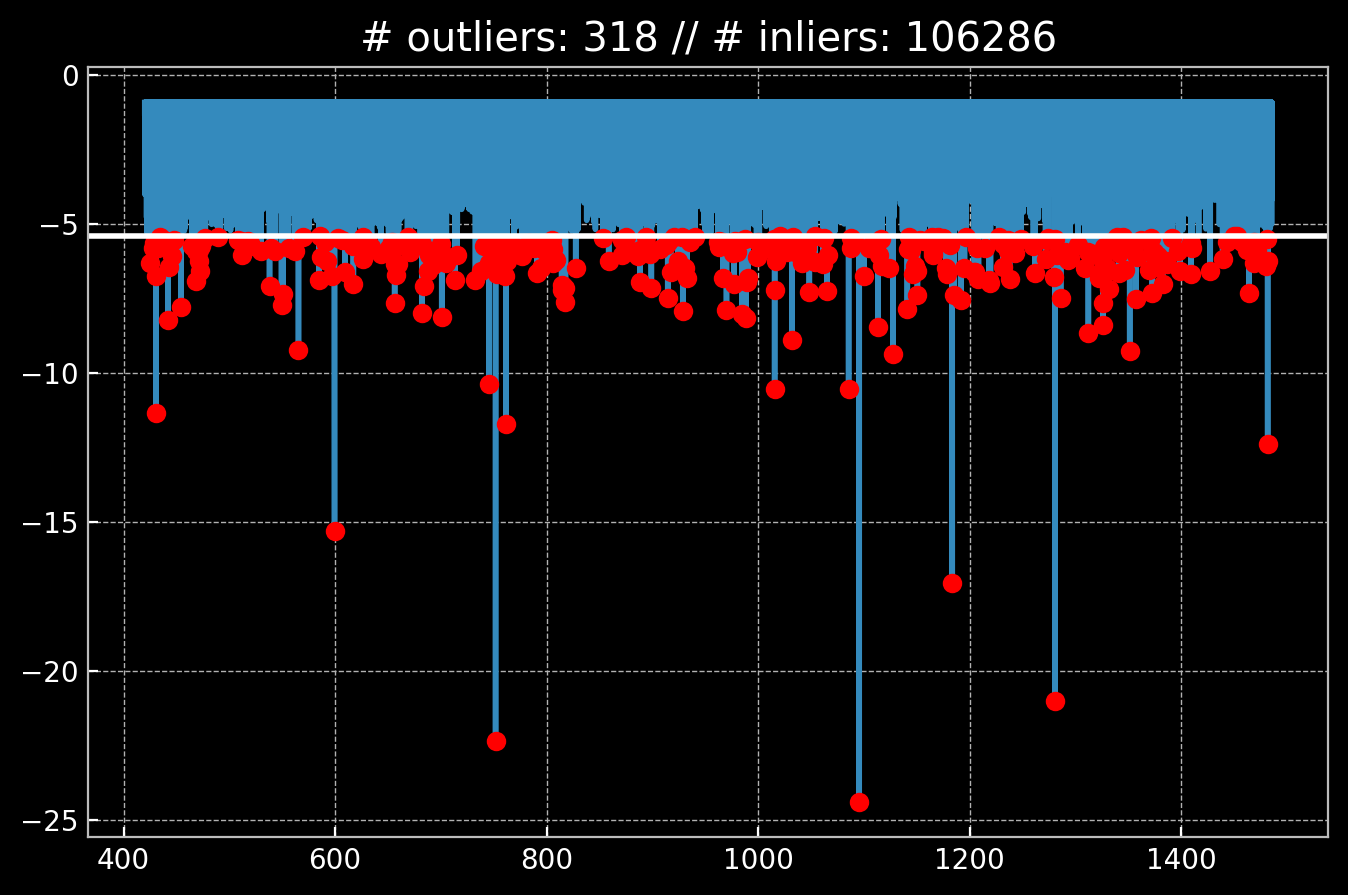

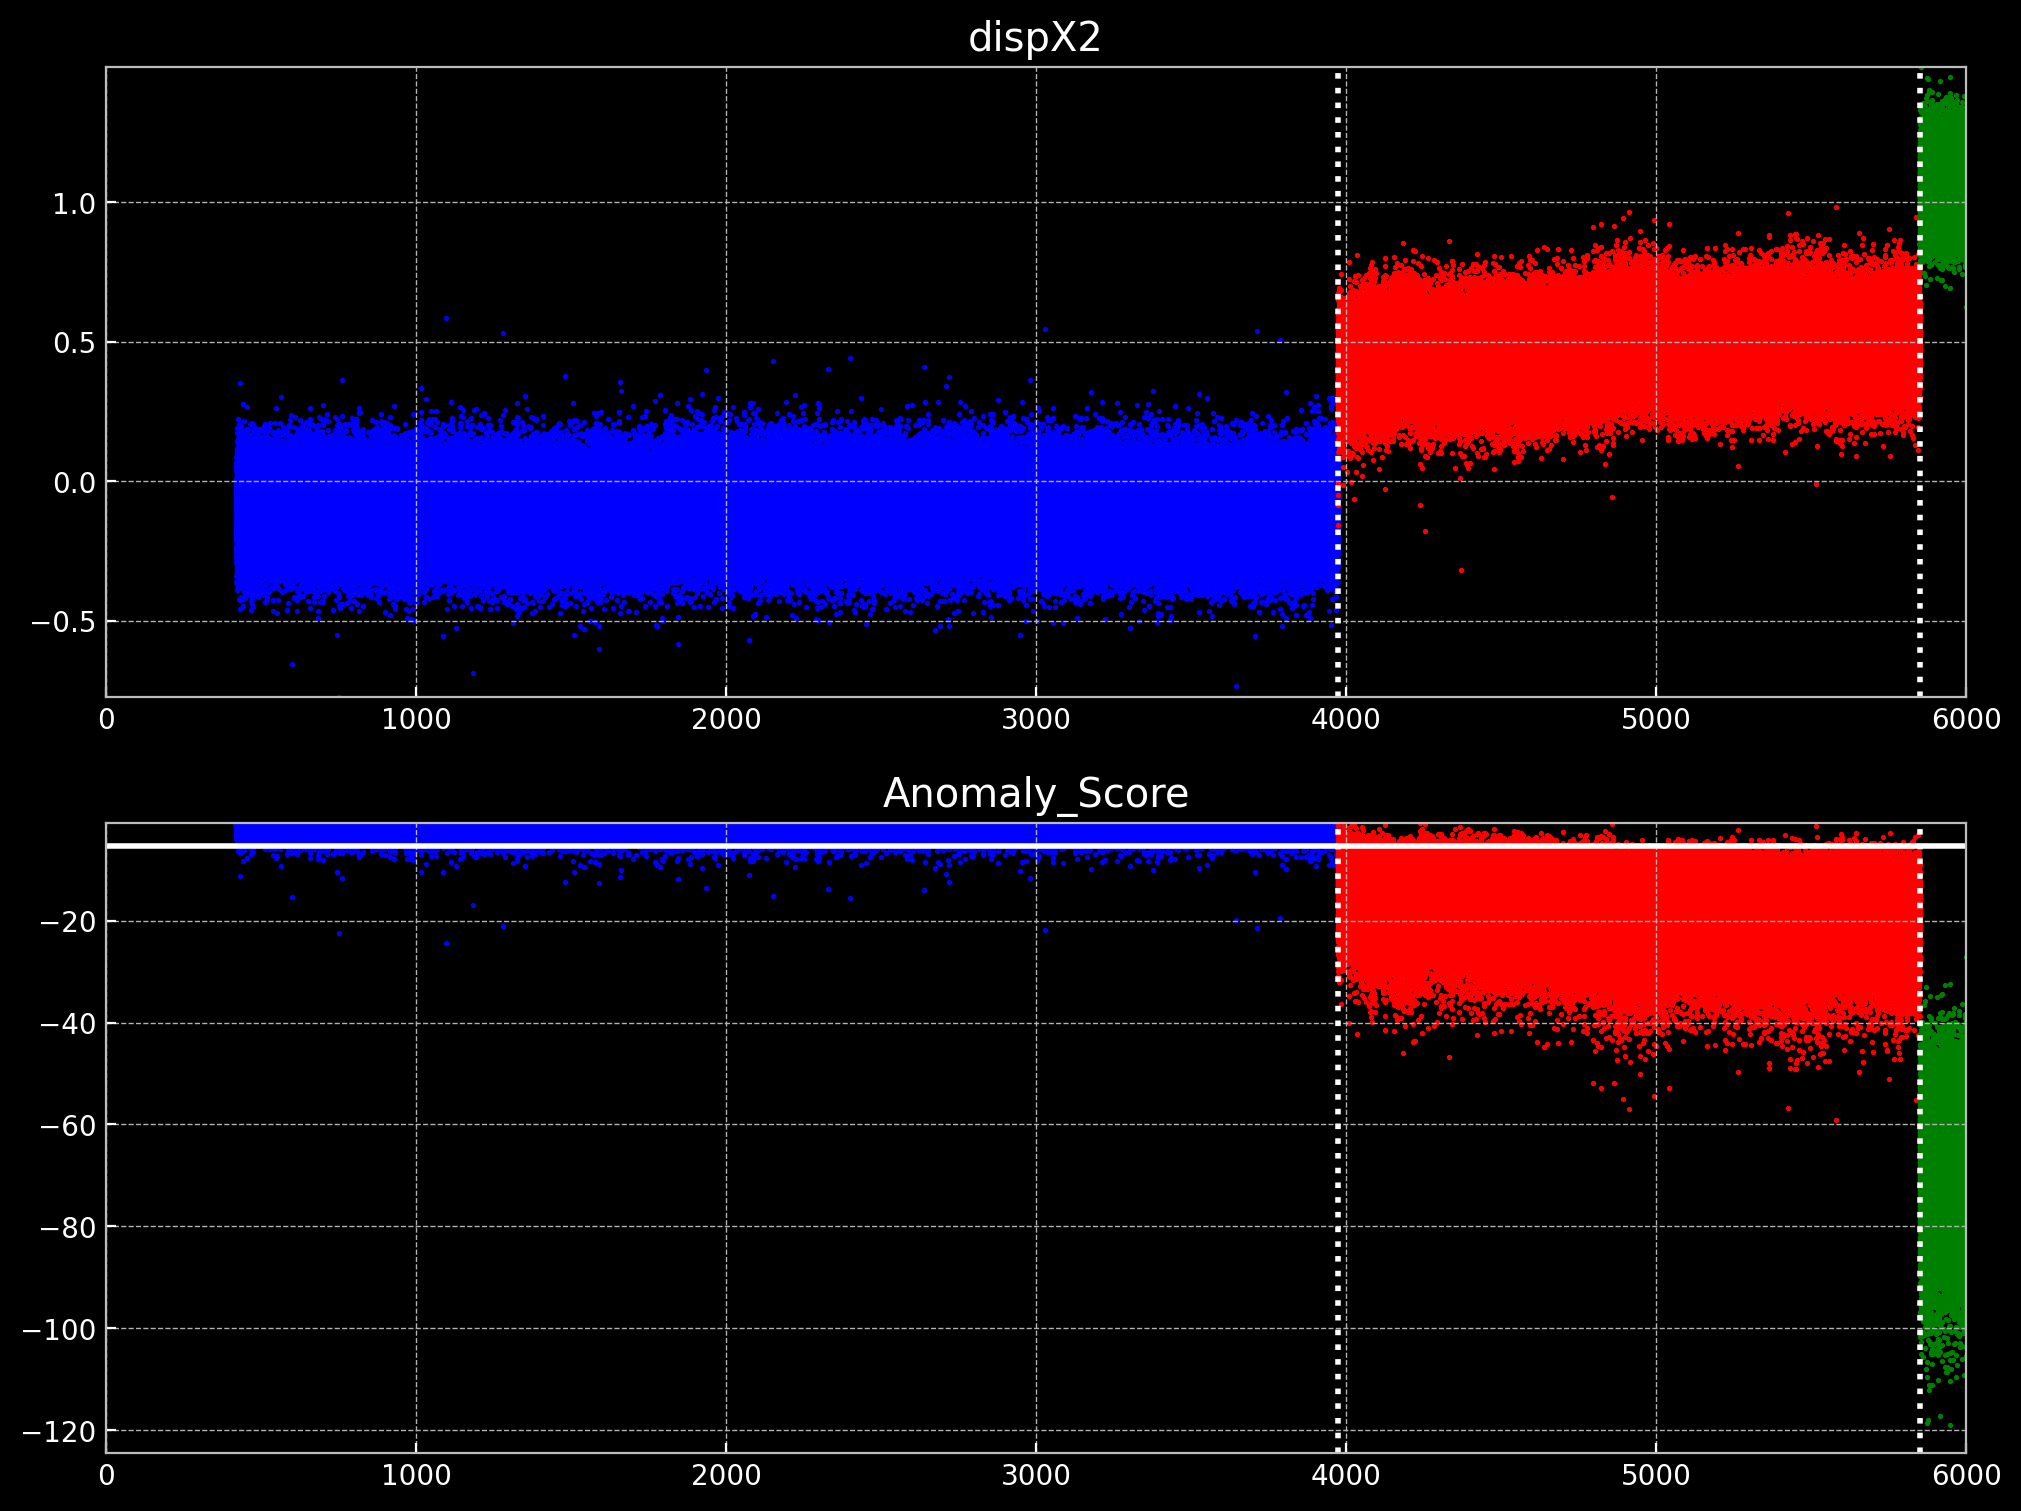

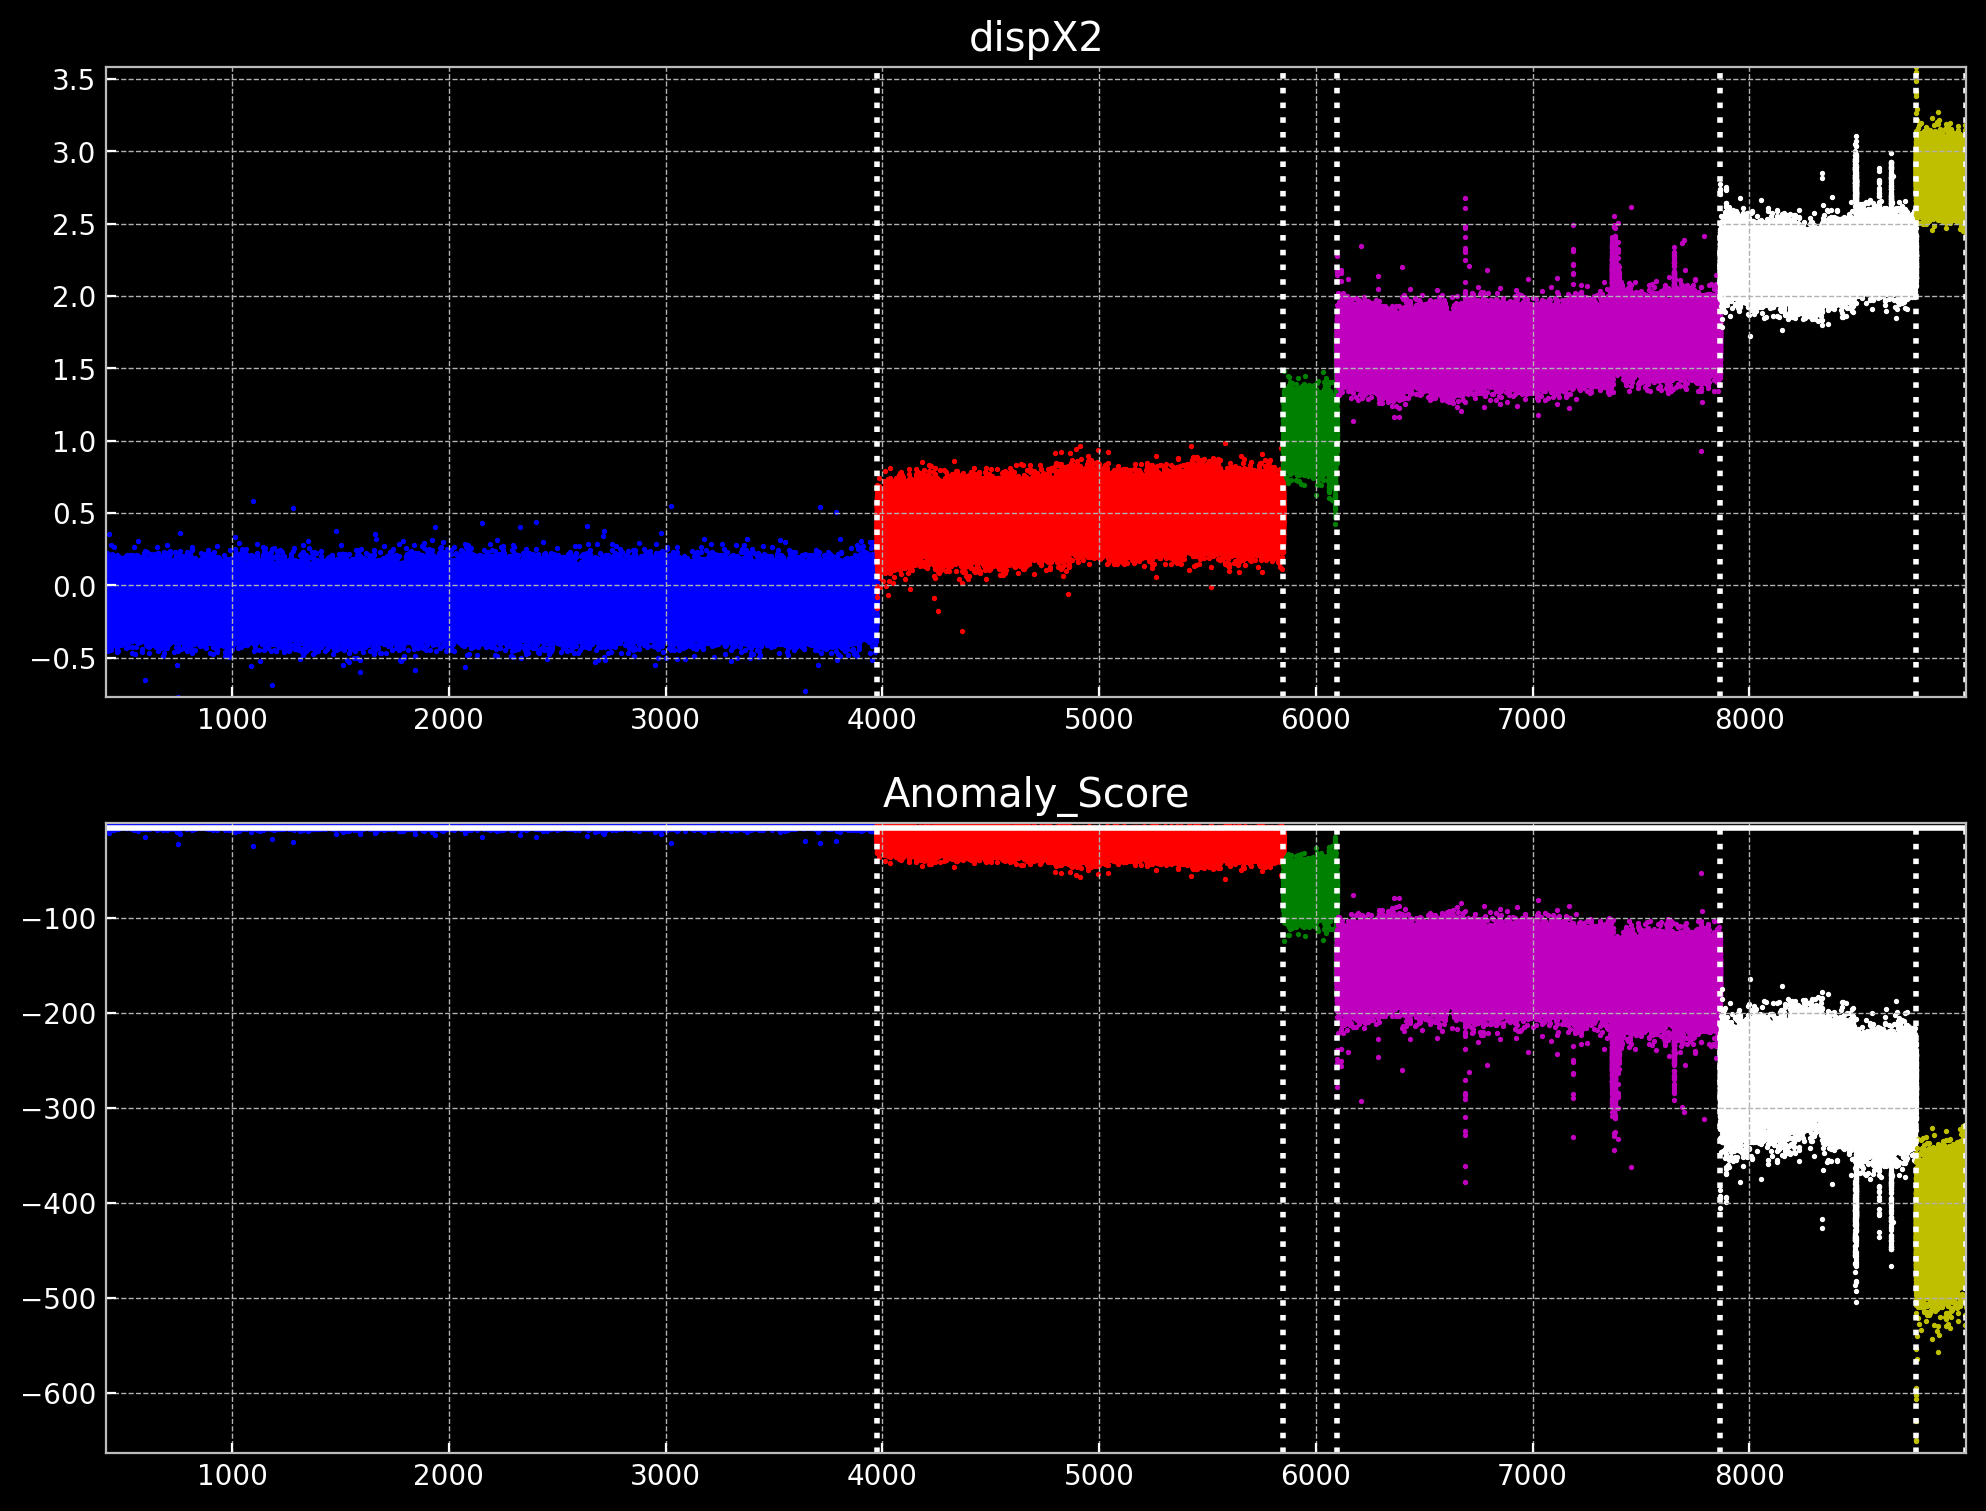

In [16]:
col_names = ['dispX2', 'Anomaly_Score']
Xtrain_uni = Xtrain_std[:, 1].reshape(-1, 1)
Xtest_uni = Xtest_std[:, 1].reshape(-1, 1)

# Automatic model selection for GMM
fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_uni, n_comp_min = 1, n_comp_max = 5)

df_gmm = []
for gmm, bic in zip(fitted_gmm, bics):
    df_gmm.append([gmm.covariance_type, gmm.n_components, bic])
df_gmm = pd.DataFrame(df_gmm, columns = ['covariance_type', 'n_component', 'bic'])
df_gmm.sort_values(by=['bic'], ignore_index = True)

# Get the anomaly score for training data
score = best_gmm.score_samples(Xtrain_uni)
df_train['Anomaly_Score'] = score

# Compute threshold from training data with significant level
pct_threshold = np.percentile(score, significance_level)

# Plot lnliers and outliers
outliers = (df_train['Anomaly_Score'] < pct_threshold)
print(f'outlier ratio : {outliers.sum()/df_train.shape[0] * 100:.2f} %')
plt.plot(df_train.index, df_train['Anomaly_Score'])
plt.plot(df_train.index[outliers], df_train.loc[outliers, 'Anomaly_Score'], 'ro', ls = 'None', label = 'outliers')
plt.title(f'# outliers: {outliers.sum()} // # inliers: {df_train.shape[0] - outliers.sum()}')
plt.axhline(pct_threshold, color = 'w')
plt.show()

# Get the anomaly score for training data
score = best_gmm.score_samples(Xtest_uni)
df_test['Anomaly_Score'] = score


# Plot result of Anomaly detection
df_all = pd.concat((df_train, df_test), axis = 0)

t_interest = (0, 6000)
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))

t_interest = (df_all.index[0], df_all.index[-1])
plot_GMM_result(df_all, col_names, t_interest, pct_threshold, figsizes = (12, 9))